In [104]:
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import zarr
import warnings
from textwrap import wrap
from mpl_toolkits import mplot3d
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from re import split
from matplotlib.animation import ArtistAnimation
from scipy.ndimage import label
from scipy.ndimage.morphology import binary_closing
import matplotlib.ticker as plticker
from skimage.filters import gaussian, threshold_otsu
from skimage import measure
from ipywidgets import interact
import dask as da
import dask
warnings.filterwarnings('ignore')
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import time_3d, get_pars_from_ini
location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
path_proj = get_pars_from_ini(campaign='loc')[location]['path_proj']
plt.rcParams['animation.html'] = 'jshtml'
%matplotlib inline

In [ ]:
# cluster = SLURMCluster(queue="seseml",
#                        memory='30GB',
#                        cores=20,
#                        processes=1,
#                        walltime='01:40:00',
#                        scheduler_options={'host': '172.22.179.3:7222', 'dashboard_address': ':7330'})

In [ ]:
# cluster.scale(4)
# cluster

In [ ]:
# %%bash
# squeue -u alfonso8

In [ ]:
# client = Client(cluster)
# client

In [2]:
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())
df_xr = pd.DataFrame(data=ds_xr.time.values, columns=['date'])
df_times = pd.read_csv(f"{get_pars_from_ini(campaign='loc')[location]['path_proj']}/src/events.txt", 
                       header=None, parse_dates=[0], names=['date'])
merged = pd.merge(df_times, df_xr, on='date',how='left')

In [77]:
ds_xr
case = ds_xr.sel(time='2019-09-16 03:12:58')
case.time.values

array(['2019-09-16T03:12:58.449800000'], dtype='datetime64[ns]')

In [72]:
# last update 10/12/2021
def lee_filter(img, size, tresh=-150):
    img = np.where(np.logical_or(np.isnan(img), np.equal(img, -np.inf)),  tresh, img)
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2
    overall_variance = variance(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output


@dask.delayed
def process(dbz, alt3d, height=500):   
    zhh14 = dbz.where(alt3d > height)
    filtered = lee_filter(zhh14, size=3, tresh=-100)    
    blurred = gaussian(filtered, sigma=.8)
    binary = blurred > threshold_otsu(blurred)
    labels = measure.label(binary)
    props = measure.regionprops(labels)
    area = [i.area for i in props]
    if any(y > 100 for y in area):
        _time =dbz.time.values
        return _time

(0.0, 8000.0)

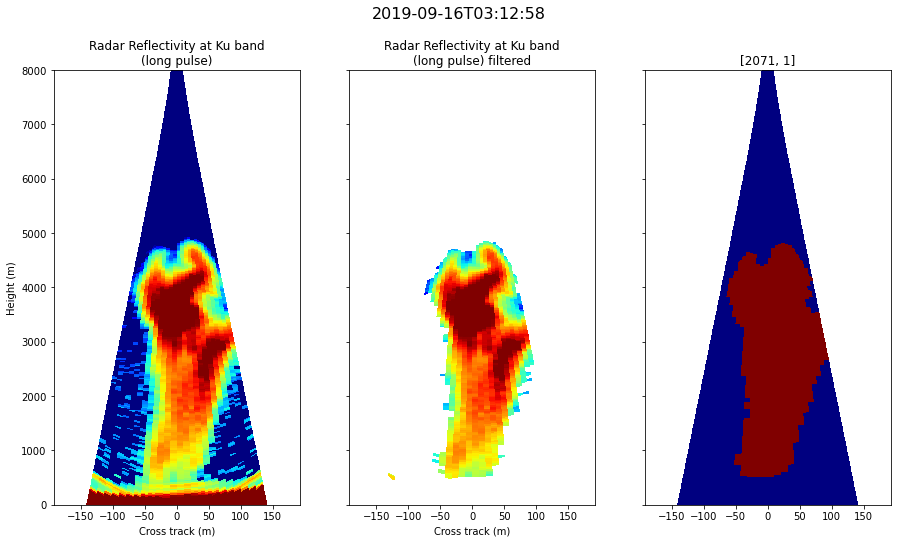

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), sharey=True)
anim = []
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())
# ds_dates = ds_xr.sel(time=slice('2019-09-16 03:12:40', '2019-09-16 03:13:40'))
ds_dates = ds_xr.isel(time=slice(175, 185))


for i in case.time:
    case = case.sel(time=i)
    height = 500
    zhh14 = case.zhh14.where(case.alt3d > height)
    
    img = lee_filter(zhh14.values, size=3, tresh=-180)
    original = np.where(img > 0, zhh14.values, 0)

    blurred = gaussian(original, sigma=0.8)
    binary = blurred > threshold_otsu(blurred)
    labels = measure.label(binary)
    props = measure.regionprops(labels)
    
    x = case.range * np.sin(np.deg2rad(case.azimuth))
    y = case.alt3D * np.cos(np.deg2rad(case.azimuth))
    
    
    im1 = ax1.pcolormesh(x, y, case.zhh14, cmap='jet', vmin=0, vmax=40)
    ax1.set_ylabel('Height (m)')
    ax1.set_xlabel('Cross track (m)')
    ax1.set_title("\n".join(wrap(case.zhh14.notes, 30)))
    
    _filtered = np.where(img > 0, zhh14.values, np.nan)
    im2 = ax2.pcolormesh(x, y, _filtered, 
                         cmap='jet',  vmin=0, vmax=40)
    ax2.set_xlabel('Cross track (m)')
    ax2.set_title("\n".join(wrap(case.zhh14.notes, 30)) + ' filtered')
    title = f"{np.datetime_as_string(case.time.values, unit='s')}\n"
    a = [i.area for i in props]
    im3 =  ax3.pcolormesh(x, y, labels, cmap='jet')
    ax3.title.set_text(f'{a}')
    fig.suptitle(title, fontsize=16, y=.99)
    
    anim.append([im1, im2, im3])

ax1.set_ylim(0, 8000)
# plt.colorbar(im1, ax=[ax1, ax2, ax3], orientation="vertical", pad=0.05, label=f'Reflectivity ({case.zhh14.units})')


In [79]:
animation = ArtistAnimation(fig, anim, interval=100)
animation

In [ ]:
### Next cells show how filter works

In [ ]:
img = lee_filter(zhh14.values, 3, -100)
original = np.where(np.logical_or(np.isnan(img), np.equal(img, -np.inf)),  -100, img)

In [ ]:
blurred = gaussian(original, sigma=.8)
binary = blurred > threshold_otsu(blurred)
labels = measure.label(binary)

plots = {'Original': original, 'Blurred': blurred, 
         'Binary': binary, 'Labels': labels}
fig, ax = plt.subplots(1, len(plots), figsize=(17, 6))

x = case.range * np.sin(np.deg2rad(case.azimuth))
y = case.alt3D * np.cos(np.deg2rad(case.azimuth))
im1 = ax1.pcolormesh(x, y, case.zhh14, cmap='jet', vmin=0, vmax=40)
for n, (title, img) in enumerate(plots.items()):
    cmap = plt.cm.gnuplot if n == len(plots) - 1 else plt.cm.gray
    ax[n].pcolormesh(x, y, img, cmap=cmap)
    ax[n].axis('off')
    ax[n].set_title(title)
    ax[n].set_ylim(0, 8000)
plt.show(fig)

props = measure.regionprops(labels)
for prop in props:
    print('Label: {} >> Object area (number of pixels): {}'.format(prop.label, prop.area))

In [85]:
case = ds_xr.sel(time='2019-09-16 03:12:58').isel(time=0)
# case = case.isel(time=0)
zhhh = case.zhh14.where(case.zhh14 > 0, np.nan)
zhhh = zhhh.where(zhhh.alt3d > 500)
img = lee_filter(zhhh.values, size=3, tresh=-180)
img  = np.where(img > 0, img, np.nan)

In [44]:
x = case.range * np.sin(np.deg2rad(case.azimuth))
y = case.alt3D * np.cos(np.deg2rad(case.azimuth))

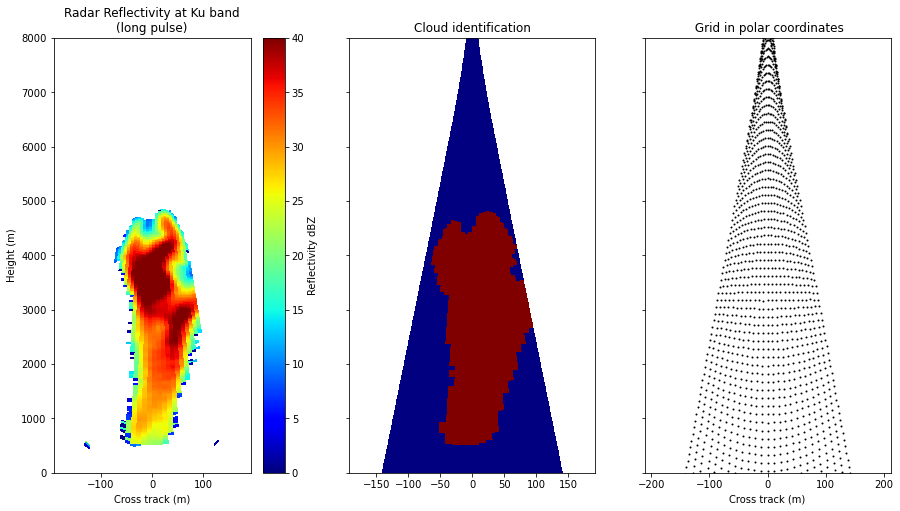

In [96]:
fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(15,8), sharey=True)
im = ax1.pcolormesh(x, y, img, vmin=0, vmax=40, cmap='jet')
ax2.scatter(x.values[::5], y.values[::5], color='k', s=1)
ax3.pcolormesh(x, y, labels, cmap='jet')
ax1.set_ylim(0, 8000)
ax1.set_xlabel('Cross track (m)')
ax1.set_ylabel('Height (m)')
ax1.set_title("\n".join(wrap(case.zhh14.notes, 30)))
ax2.set_title(" Grid in polar coordinates")
ax2.set_xlabel('Cross track (m)')
ax3.set_title("Cloud identification")
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Reflectivity dBZ')
# ax2.grid()
plt.savefig('../results/polar_grid.jpg')

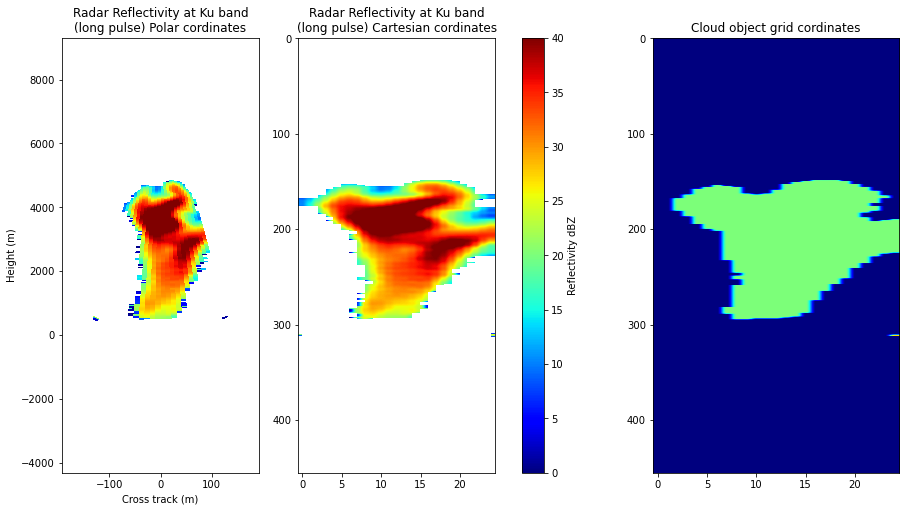

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
im = ax1.pcolormesh(x, y, img, vmin=0, vmax=40, cmap='jet')
im2 = ax2.imshow(img, aspect='auto', vmin=0, vmax=40, cmap='jet')
ax1.set_xlabel('Cross track (m)')
ax1.set_ylabel('Height (m)')
ax1.set_title("\n".join(wrap(case.zhh14.notes, 30)) + ' Polar cordinates')
ax2.set_title("\n".join(wrap(case.zhh14.notes, 30)) + ' Cartesian cordinates')

cbar = plt.colorbar(im, ax=[ax1, ax2])
cbar.set_label('Reflectivity dBZ')
ax3.imshow(labels, cmap='jet', aspect='auto')
ax3.set_title('Cloud object grid cordinates')
plt.savefig('../results/polar_cartesian.jpg')

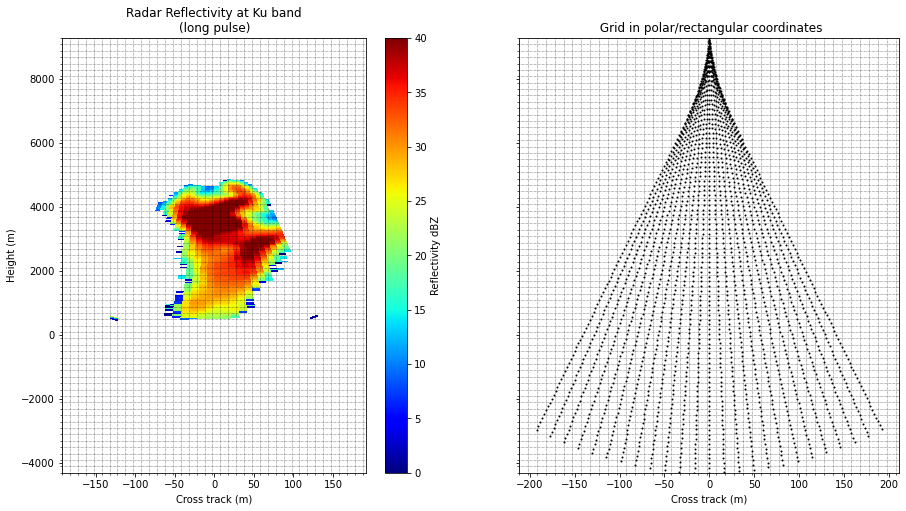

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8), sharey=True)
im = ax1.pcolormesh(x, y, img, vmin=0, vmax=40, cmap='jet')
ax2.scatter(x.values[::5], y.values[::5], color='k', s=1)
ax1.set_ylim(0, 8000)
ax1.set_xlabel('Cross track (m)')
ax1.set_ylabel('Height (m)')
ax1.set_title("\n".join(wrap(case.zhh14.notes, 30)))
ax2.set_title(" Grid in polar/rectangular coordinates")
ax2.set_xlabel('Cross track (m)')
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Reflectivity dBZ')
ax1.set_yticks(np.arange(y.values.min(), y.values.max(), 200), minor=True)
ax1.set_xticks(np.arange(x.values.min(), x.values.max(), 10), minor=True)
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax2.set_yticks(np.arange(y.values.min(), y.values.max(), 200), minor=True)
ax2.set_xticks(np.arange(x.values.min() - 20, x.values.max() + 20, 10), minor=True)
# ax2.grid()
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.savefig('../results/cartesian_1.jpg')